In [3]:
#@title imports 
import os
import pickle
from typing import Set
# from jedi import settings
import numpy as np 
import matplotlib.pyplot as plt
from numpy.lib.function_base import append 
import scipy.io as spio
from scipy.io import loadmat, savemat
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from scipy.sparse import data 
import pandas as pd 
import matplotlib as mpl 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import SparsePCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import umap.plot as uplot
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import sys 

sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *
from sknetwork.clustering import Louvain,get_modularity
from sknetwork.data import karate_club
import umap
pd.options.mode.use_inf_as_na = True

In [4]:
from Cluster_stability import * 

In [17]:

def binarize_EI_labels(labels, e_vals):
    temp_labels = labels
    for idx,vals in enumerate(labels):
        if vals in e_vals:
            temp_labels[idx] =1
        else:
            temp_labels[idx] =0 

    return temp_labels


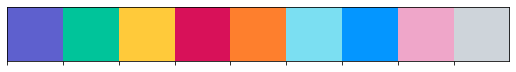

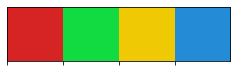

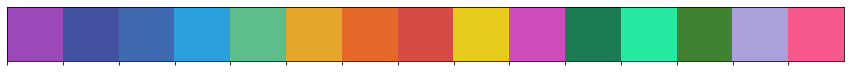

In [5]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380"]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.251,	0.412, 0.698],
                    [0.176,	0.631, 0.859],
                    [0.369,	0.749, 0.549],
                    [0.898,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.812,	0.3 , 0.734],
                    [0.109, 0.483, 0.324],
                    [0.159,	0.914, 0.635],
                    [0.251,	0.512, 0.198],
                    [0.676,	0.631, 0.859],
                    [0.969,	0.349, 0.549],]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [6]:
discarded_exps = ['xuan_151118_E1',
'xuan_15319_E1' ,
'xuan_20919_E2',
'xuan_27919_E1',
'xuan_27919_E2',
'xuan_27919_E3',
'NC_20717_E5' ,
'NC_25717_E2',
'payam_31019_E5',
'payam_101019_E5',
'NC_24717_E1']

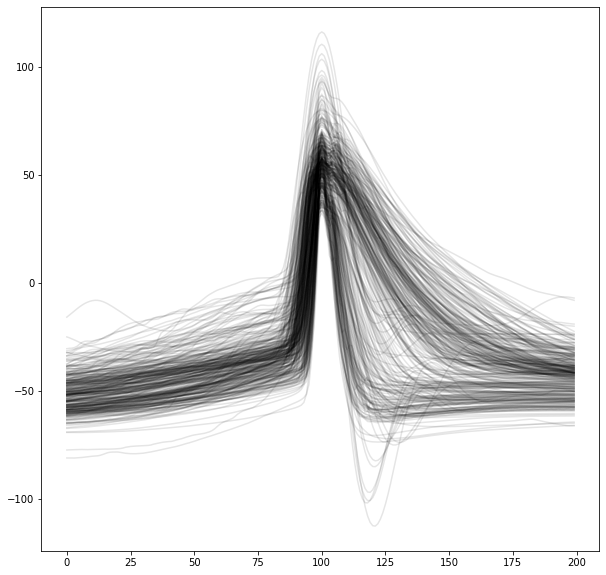

In [7]:
# %matplotlib widget

ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_spikes_calculated.pkl")
ephys = ephys[~ephys.exp_name.isin(discarded_exps)]


data_ephys_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][ephys.columns[1:]]
data_ephys_FN_acsf = data_ephys_FN_acsf[data_ephys_FN_acsf.trialnr==0]


data_wave_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][['waveform','tau', 'exp_name', 'cond', 'trialnr']]
data_wave_FN_acsf=data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]
data_wave_FN_acsf.drop_duplicates('exp_name')

# exps_with_double_trials = np.array(data_wave_FN_acsf.exp_name)[list(np.where(np.unique(data_wave_FN_acsf.exp_name,return_counts=True)[1]>1)[0])]
# data_wave_FN_acsf = data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]

fig,ax = plt.subplots(figsize=[10,10])
# plt.ion
plt.plot(np.vstack(data_wave_FN_acsf['waveform']).T,c='k',alpha=0.1)
plt.show()


In [39]:
def plot_UMAP_clusters_single(data_inh, neighbours, distance, res_louvain, random_state,plot=True, annotate=False,norm=True, c_list=None ,title=None,save=False):
    """plots UMAP for excitatory and inhibitory cells 

    Args:
        data_inh (ndarray): cell X feature matrix for inhibitory cells
        data_exc (ndarray): cell X feature matrix for excitatory cells
        c_exc (array): _description_
        c_inh (array): _description_
        neighbours (int): number of neares neighbours
        distance (float): minimum distance between points
    """
    data_umap_scaler = StandardScaler()
    data_umap = data_umap_scaler.fit_transform(data_inh)
    if norm:
        data_umap = normalize(data_umap)
    
    neighbours = neighbours
    dist = distance
    reducer = umap.UMAP(n_neighbors=neighbours,min_dist=dist,random_state=random_state)
    mapper = reducer.fit(data_umap)
    
    fig = plt.figure(figsize=[8,8])
    ax12d = fig.add_subplot(1,1,1)
    
    louvain = Louvain(resolution=res_louvain,random_state=random_state)
    adjacency = mapper.graph_
    labels_exc = louvain.fit_predict(adjacency)

    print(len(set(labels_exc)))
    clusterable_embedding2d = umap.UMAP(n_neighbors=neighbours,min_dist=dist,
        n_components=2,random_state=random_state,).fit_transform(data_umap)



    df_2d_exc = {'UMAP1':clusterable_embedding2d[:, 0],
             'UMAP2':clusterable_embedding2d[:, 1],
             'class':labels_exc}

    ax12d.set_xticks([])
    ax12d.set_yticks([])
    if plot:
        sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',palette=c_list[:len(set(labels_exc))],ax=ax12d)
        if annotate:
            for i in range(len(clusterable_embedding2d)):

                plt.annotate(str(i),(clusterable_embedding2d[i,0]+0.05,clusterable_embedding2d[i,1]+0.05))

            # sns.scatterplot(data=df_2d_exc,x='UMAP1',y='UMAP2',hue='class',ax=ax12d)

            # ax12d.set_title('UMAP clusters for excitatory neurons 2D')
            ax12d.legend()
        if save:
            plt.savefig('C:/Users/Nishant Joshi/Documents/DNM/exc_umap_cluster.png',dpi=200)
        if title!=None:
            plt.title(title)
        plt.show()

    return labels_exc,mapper,reducer

In [9]:
waves = normalize(np.vstack(data_wave_FN_acsf['waveform']))

# find_optimum_res(waves)

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


8


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


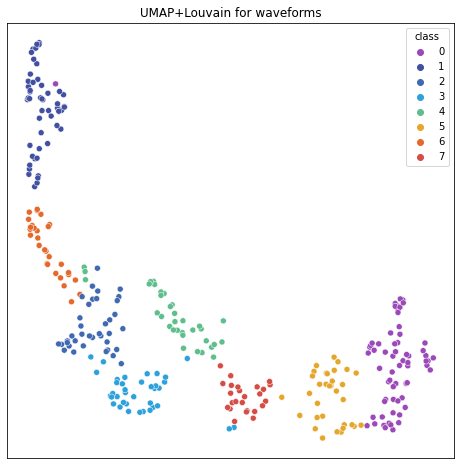

In [10]:
labels_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list =coherence_colors,
                          title='UMAP+Louvain for waveforms')
data_wave_FN_acsf['labels_wave'] = labels_wave

0


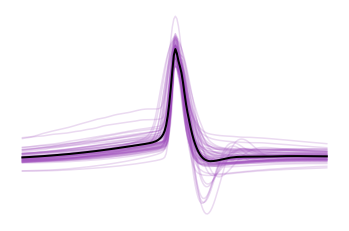

1


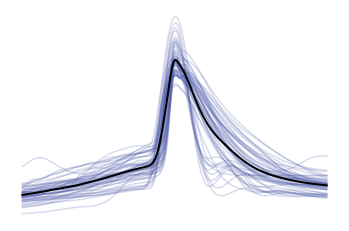

2


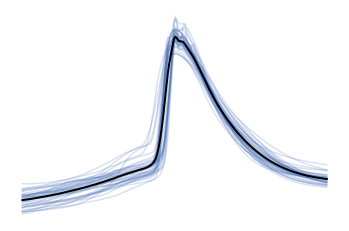

3


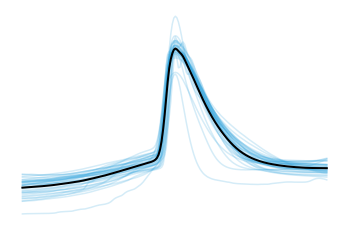

4


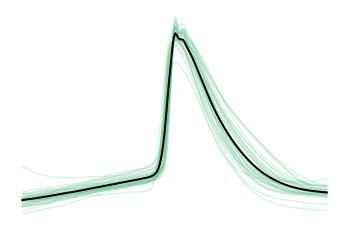

5


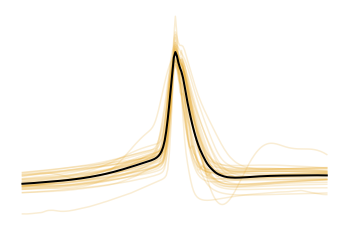

6


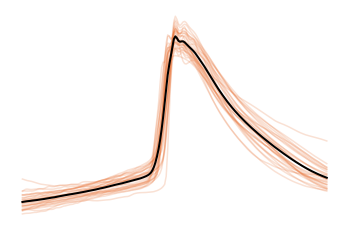

7


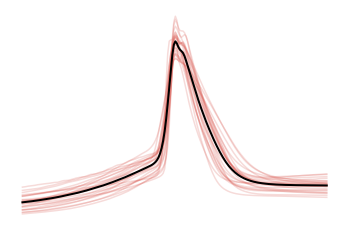

In [11]:
for i in set(labels_wave):
    print(i)
    fig,ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    # data_wave_FN_acsf[data_wave_FN_acsf.labels_wave==i]['half_width']
    plt.plot(np.arange(0,10,1/20),(np.vstack(data_wave_FN_acsf[data_wave_FN_acsf.labels_wave==i]['waveform']).T),c=coherence_colors[i],alpha=0.2)
    plt.plot(np.arange(0,10,1/20),np.mean(np.vstack(data_wave_FN_acsf[data_wave_FN_acsf.labels_wave==i]['waveform']).T,axis=1),c='black',linewidth=2,label=i)
    plt.xticks([])
    plt.yticks([])
    plt.show()
# plt.legend()

In [12]:
data_ephys_FN_acsf['labels_wave'] = labels_wave

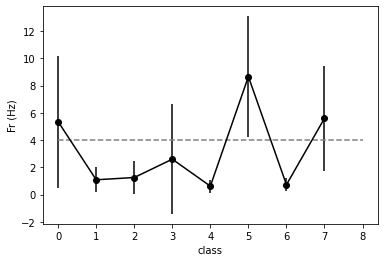

<ipython-input-13-ef519c298065>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(ap_width[i],frs[i],marker='o',c=coherence_colors[i],label = list(set(data_ephys_FN_acsf['labels_wave']))[i])


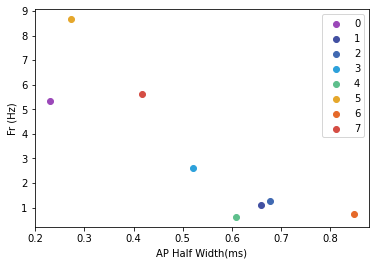

In [13]:
frs = []
ap_width = []  
frs_std = []
ap_width_std = []

for i in set(data_ephys_FN_acsf['labels_wave']):
    frs.append(np.mean(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['fr']))
    frs_std.append(np.std(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['fr']))

    ap_width.append(np.mean(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['mean_width']))
    ap_width_std.append(np.std(data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave==i]['mean_width']))

plt.errorbar(list(set(data_ephys_FN_acsf['labels_wave'])),frs,yerr=frs_std,marker='o',c='black')
plt.hlines(4,0,8,linestyles='dashed',color='grey')
plt.ylabel('Fr (Hz)')
plt.xlabel('class')
plt.show()

for i in range(len(ap_width)):
    plt.scatter(ap_width[i],frs[i],marker='o',c=coherence_colors[i],label = list(set(data_ephys_FN_acsf['labels_wave']))[i])
    plt.ylabel('Fr (Hz)')
    plt.xlabel('AP Half Width(ms)')
    plt.legend()
plt.show()

In [ ]:
cols = ephys_exc.columns[:-5]
data = ephys_exc[cols].to_numpy()

dict_saved_exc = find_optimum_res_with_cols(data,cols)

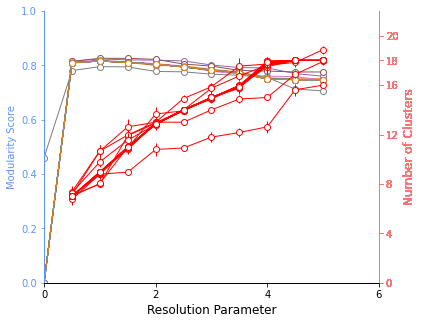

In [79]:
plot_clust_res(dict_saved_exc)


In [14]:
def return_confusion_matrix(df1,df2,label1_name,label2_name):
    df = pd.DataFrame(columns=['label1','label2'])
    df['exp_name1'] = df1.exp_name
    df['exp_name2'] = df2.exp_name
    df['label1'] = np.array(df1[label1_name])
    df['label2'] = np.array(df2[label2_name])

    mat = np.zeros((len(set(df1[label1_name])),len(set(df2[label2_name]))))

    for i in np.unique(df.label1):
        data_ = np.unique(df[df.label1==i]['label2'],return_counts=True)
        mat[i,data_[0]] =(data_[1]/np.sum(data_[1]))*100 

    sns.heatmap(mat,cmap='BrBG_r',annot=True) 

    plt.show()

<Axes: >

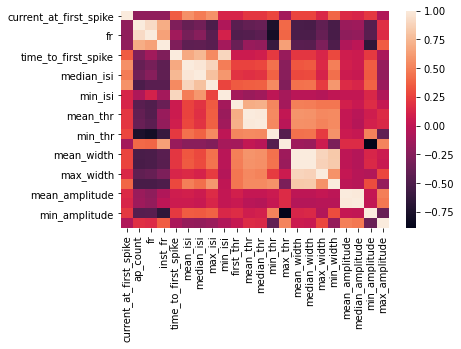

In [15]:
sns.heatmap(data_ephys_FN_acsf[['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',]].corr())


In [18]:
data_ephys_FN_acsf

,current_at_first_spike,ap_count,fr,inst_fr,time_to_first_spike,mean_isi,median_isi,max_isi,min_isi,first_thr,...,min_width,mean_amplitude,median_amplitude,min_amplitude,max_amplitude,tau,exp_name,cond,trialnr,labels_wave
0,208.833286,3002,8.675,0.029865,172.4,119.895285,50.75,1586.15,6.65,-52.718751,...,0.25,94.187479,94.359376,57.593752,138.031252,50,asli_18719_E2,acsf,0,5
3,267.928454,175,0.523333,0.006817,8311.0,2011.697126,1098.9,15342.55,15.5,-41.6875,...,0.525,96.395714,96.312501,64.812502,128.406249,250,asli_11719_E1,acsf,0,4
6,214.58999,107,0.33,0.002241,8315.05,3295.918868,2081.85,17332.4,26.4,-39.250001,...,0.825,87.150117,87.0625,67.156252,105.812501,250,asli_11719_E2,acsf,0,6
9,60.675047,1222,3.853333,0.021232,1143.95,293.688984,134.65,2412.3,4.8,-35.843749,...,0.175,99.079941,99.468751,10.59375,150.90625,250,asli_12719_E2,acsf,0,7
12,83.323528,1595,4.422222,0.020182,170.7,225.725847,109.7,2348.5,4.05,-51.718749,...,0.15,105.893025,104.125001,70.250003,368.875004,50,asli_12719_E3,acsf,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,312.814705,265,0.806667,0.00937,8302.8,1325.886742,745.45,10718.7,8.0,-46.843749,...,0.5,103.208019,102.968752,59.78125,139.562503,250,xuan_9519_E4,acsf,0,2
828,253.895342,3103,9.111111,0.038934,170.65,115.993681,42.225,1586.6,5.1,-53.125001,...,0.25,94.693019,96.187502,54.6875,143.250003,50,xuan_9919_E1,acsf,0,5
831,272.63587,110,0.33,0.002705,8311.0,3205.217431,1971.65,17334.1,18.5,-37.687499,...,0.8,90.05625,90.078125,68.062501,119.687501,250,xuan_9919_E2,acsf,0,6
834,26.163187,865,2.402778,0.016246,1560.75,414.839873,227.075,3302.75,4.95,-49.874999,...,0.125,121.959249,122.437503,0.0,144.593745,50,xuan_9919_E3,acsf,0,0


In [19]:

ephys_exc  = data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave.isin([1,2,3,4,6])]
ephys_inh  = data_ephys_FN_acsf[data_ephys_FN_acsf.labels_wave.isin([0,5,7])]


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


8


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


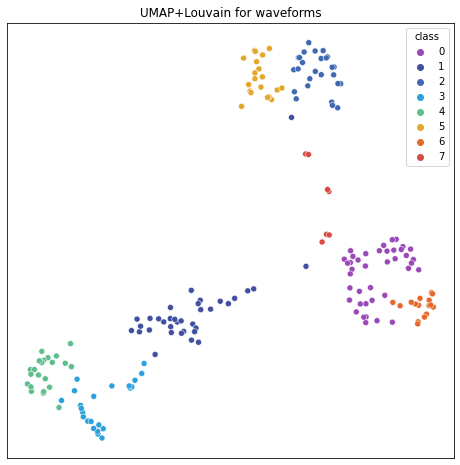

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


7


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


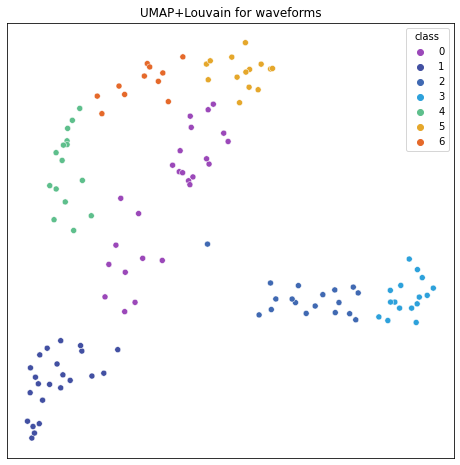

<ipython-input-20-ee41479bc789>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ephys_exc['labels_ephys'] = lables_ephys_exc
<ipython-input-20-ee41479bc789>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ephys_inh['labels_ephys'] = lables_ephys_inh


In [20]:
cols =  data_ephys_FN_acsf.columns[:-6]
ephys_data = normalize(np.vstack(ephys_exc[cols].to_numpy()))
lables_ephys_exc,mapper,reducer = plot_UMAP_clusters_single(ephys_data,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list =coherence_colors,
                          title='UMAP+Louvain for waveforms')

ephys_data = normalize(np.vstack(ephys_inh[cols].to_numpy()))
lables_ephys_inh,mapper,reducer = plot_UMAP_clusters_single(ephys_data,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list =coherence_colors,
                          title='UMAP+Louvain for waveforms')
ephys_exc['labels_ephys'] = lables_ephys_exc
ephys_inh['labels_ephys'] = lables_ephys_inh 

In [21]:
def return_name_date_exp_fn(string):

  if 'NC' in string:
    string_broken = string.split('_')
    name = string_broken[0]
    date = string_broken[1]
    exp = string_broken[-1]
    year = date[:2]
    month = date[2:4]

    if month[0] =='0':
      month = month[1]
    day = date[4:]
    if day[0] =='0':
      day = day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp 
  elif 'xuan' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1].replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp
  elif 'asli' in string:
    broken_str = string.split('_')
    name = broken_str[0]
    date = broken_str[1]
    date = date.replace('-','')
    exp =  broken_str[2]
    return name+'_'+date+'_'+exp    
  elif 'Payam' in string or 'payam' in string :
    broken_str = string.split('_')
    name = broken_str[0].lower()
    date = broken_str[1].split('-')
    exp =  broken_str[2]
    day = date[0]
    month = date[1]
    year = date[2]
    if day[0] =='0':
      day=day[1]
    date = day+month+year  
    return name+'_'+date+'_'+exp

In [24]:
df = pd.read_csv('D:/Biophysical_cluster/cluster_params_rect_filt.csv')
df.exp_name = df.exp_name.apply(return_name_date_exp_fn)
df = df[~df.exp_name.isin(discarded_exps)]
df = df[df.columns[1:]]
df_acsf = df[df.cond.isin(['ACSF','aCSF','aCSF_BIC'])]
df_acsf = df_acsf[df_acsf.trial==0]
df_acsf['labels_wave']=binarize_EI_labels(labels_wave,[1,2,3,4,6])



In [25]:
df[['tau_m (ms)', 'R (MOhm):', 'C (nF):', 'gl (nS):', 'El (mV):', 'Vr (mV):', 'Vt* (mV):', 'DV (mV):',]].corr()
# sns.heatmap(df[[ 'C (nF):', 'gl (nS):', 'El (mV):', 'Vr (mV):', 'Vt* (mV):', 'DV (mV):',]].corr())

,tau_m (ms),R (MOhm):,C (nF):,gl (nS):,El (mV):,Vr (mV):,Vt* (mV):,DV (mV):
tau_m (ms),1.000000,-0.053907,0.598248,0.598858,-0.077879,-0.118030,-0.200028,-0.010177
R (MOhm):,-0.053907,1.000000,-0.076511,-0.089572,0.403039,-0.264189,-0.561245,0.170999
C (nF):,0.598248,-0.076511,1.000000,0.999604,-0.009124,-0.029209,-0.055192,0.033892
gl (nS):,0.598858,-0.089572,0.999604,1.000000,-0.014338,-0.025693,-0.049263,0.030770
El (mV):,-0.077879,0.403039,-0.009124,-0.014338,1.000000,-0.180722,0.001988,-0.163073
Vr (mV):,-0.118030,-0.264189,-0.029209,-0.025693,-0.180722,1.000000,0.531130,0.664784
Vt* (mV):,-0.200028,-0.561245,-0.055192,-0.049263,0.001988,0.531130,1.000000,0.079335
DV (mV):,-0.010177,0.170999,0.033892,0.030770,-0.163073,0.664784,0.079335,1.000000


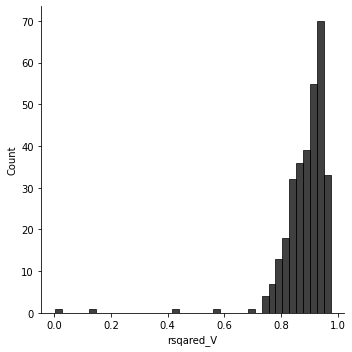

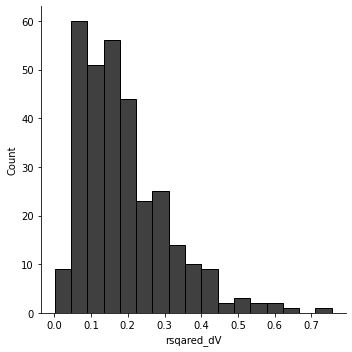

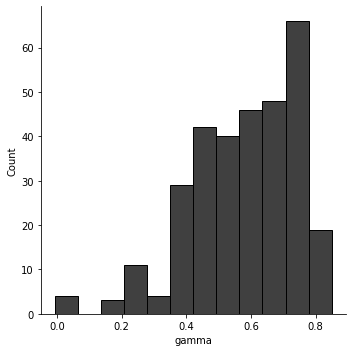

In [26]:
sns.displot(df_acsf['rsqared_V'],color='black')
plt.show()
sns.displot(df_acsf['rsqared_dV'],color='black')
plt.show()
sns.displot(df_acsf['gamma'],color='black')
plt.show()

In [27]:
df_biophys_exc = df_acsf[df_acsf.labels_wave ==1]
df_biophys_inh = df_acsf[df_acsf.labels_wave == 0 ]


In [28]:
df_biophys_exc = df_biophys_exc[df_biophys_exc.rsqared_V>0.7]
df_biophys_inh = df_biophys_inh[df_biophys_inh.rsqared_V>0.7]

In [ ]:
find_optimum_res(bio_phys_inh)

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


9


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


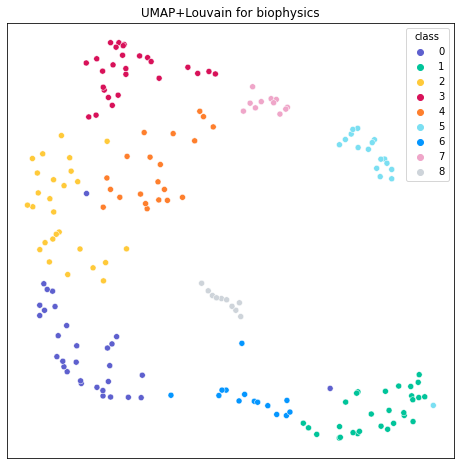

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


9


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


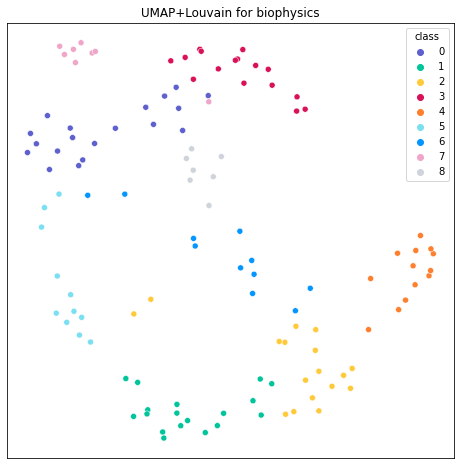

In [29]:
cols_bio = [ 'C (nF):', 'gl (nS):', 'El (mV):', 'Vr (mV):', 'Vt* (mV):', 'DV (mV):',]
bio_phys_exc = normalize(np.vstack(df_biophys_exc[cols_bio].to_numpy()))
lables_bio_exc,mapper,reducer = plot_UMAP_clusters_single(bio_phys_exc,
                          20,
                          0.1,
                          random_state =30,
                          res_louvain = 1.,
                          c_list =CUSTOM_PAL_SORT_3,
                          title='UMAP+Louvain for biophysics'
                          )

bio_phys_inh = normalize(np.vstack(df_biophys_inh[cols_bio].to_numpy()))
lables_bio_inh,mapper,reducer = plot_UMAP_clusters_single(bio_phys_inh,
                          20,
                          0.1,
                          random_state =30,
                          res_louvain = 1.,
                          c_list =CUSTOM_PAL_SORT_3,
                          title='UMAP+Louvain for biophysics'
                          )
df_biophys_exc['lables_bio'] = lables_bio_exc
df_biophys_inh['lables_bio'] = lables_bio_inh

In [30]:
df_sta = pd.read_pickle('D:/CurrentClamp/all_stas_hidden_spikes_computed.pkl')
df_sta.trial = df_sta.trial.apply(int)
df_sta = df_sta[~df_sta.exp_name.isin(discarded_exps)]
df_sta_acsf = df_sta[df_sta.cond.isin(['acsf','acsf_bic'])]

df_sta_acsf = df_sta_acsf[df_sta_acsf.exp_name.isin(set(data_wave_FN_acsf.exp_name))]
df_sta_acsf = df_sta_acsf[df_sta_acsf.trial==0]



In [31]:
df_sta_acsf['labels_wave'] =labels_wave 

df_sta_acsf_exc = df_sta_acsf[df_sta_acsf.labels_wave.isin([1,2,3,4,6])]
df_sta_acsf_inh = df_sta_acsf[df_sta_acsf.labels_wave.isin([0,5,7])]

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


8


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


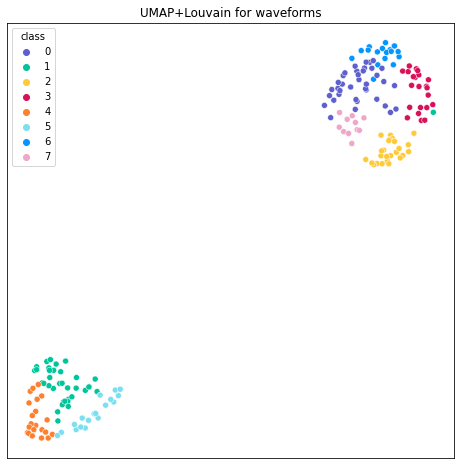

c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


6


c:\Users\Nishant Joshi\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


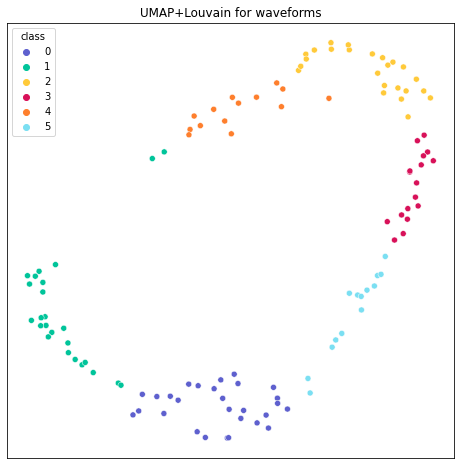

<ipython-input-32-2f860cab4eff>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sta_acsf_exc['labels_sta'] =labels_sta_exc
<ipython-input-32-2f860cab4eff>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sta_acsf_inh['labels_sta'] =labels_sta_inh


In [32]:
sta_exc = normalize(np.vstack(df_sta_acsf_exc['sta'].to_numpy()))
labels_sta_exc,mapper,reducer = plot_UMAP_clusters_single(sta_exc,
                          20,
                          0.1,
                          random_state =30,
                          res_louvain = 1.,
                          c_list =CUSTOM_PAL_SORT_3,
                          title='UMAP+Louvain for waveforms'
                          )

sta_inh = normalize(np.vstack(df_sta_acsf_inh['sta'].to_numpy()))
labels_sta_inh,mapper,reducer = plot_UMAP_clusters_single(sta_inh,
                          20,
                          0.1,
                          random_state =30,
                          res_louvain = 1.,
                          c_list =CUSTOM_PAL_SORT_3,
                          title='UMAP+Louvain for waveforms'
                          )

df_sta_acsf_exc['labels_sta'] =labels_sta_exc
df_sta_acsf_inh['labels_sta'] =labels_sta_inh

In [33]:
stas = np.vstack(df_sta_acsf_exc[df_sta_acsf_exc.labels_sta==4]['sta'])
exps = df_sta_acsf_exc[df_sta_acsf_exc.labels_sta==4]['exp_name']



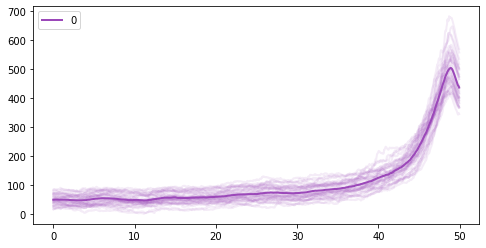

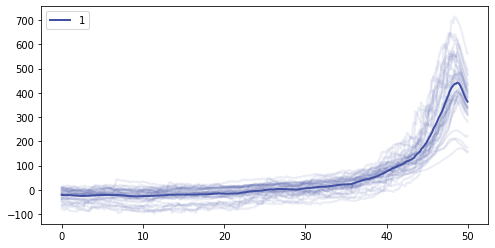

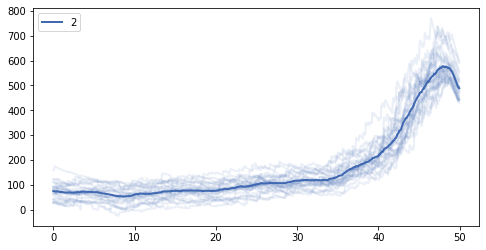

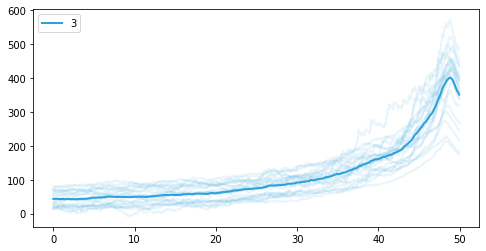

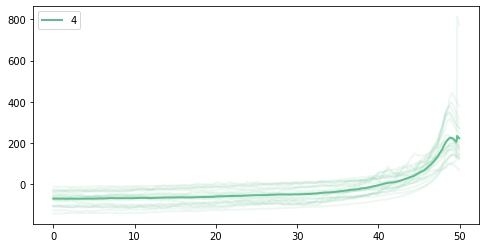

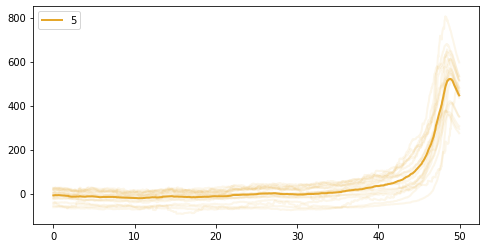

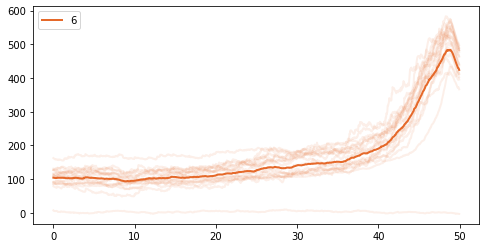

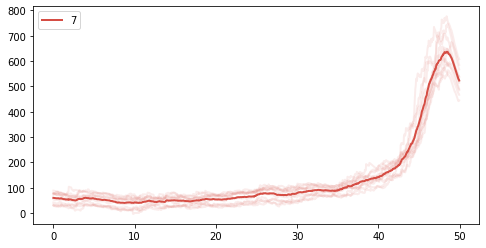

In [34]:
for i in set(df_sta_acsf_exc.labels_sta):
    fig,ax = plt.subplots(figsize=[8,4])
    plt.plot(np.arange(0,50,1/20),np.vstack(df_sta_acsf_exc[df_sta_acsf_exc.labels_sta==i]['sta']).T[50*20:],c=coherence_colors[i],linewidth=2,alpha=0.1)
    plt.plot(np.arange(0,50,1/20),np.mean(np.vstack(df_sta_acsf_exc[df_sta_acsf_exc.labels_sta==i]['sta']).T,axis=1)[50*20:],c=coherence_colors[i],linewidth=2,label=i)
    plt.legend()
    plt.show()

# for i in set(df_sta_acsf_inh.labels_sta):
#     plt.plot(np.arange(0,50,1/20),np.mean(np.vstack(df_sta_acsf_inh[df_sta_acsf_inh.labels_sta==i]['sta']).T,axis=1)[50*20:],c=coherence_colors[i],linewidth=2,label=i)
# plt.legend()    
# plt.show()

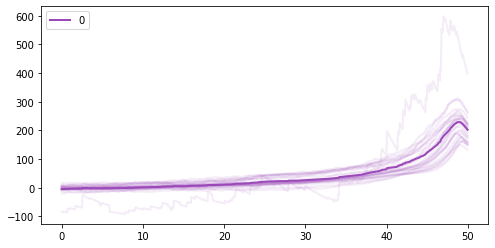

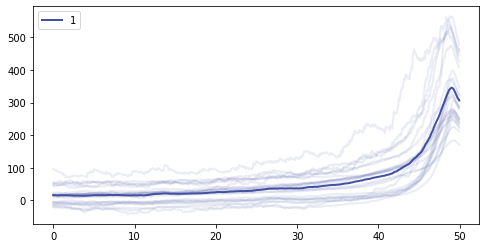

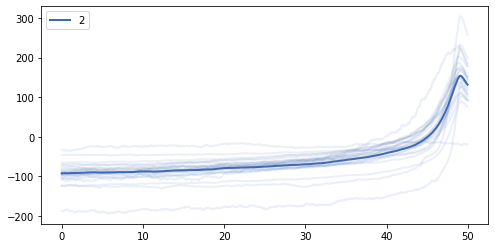

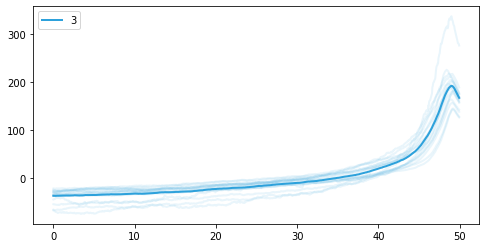

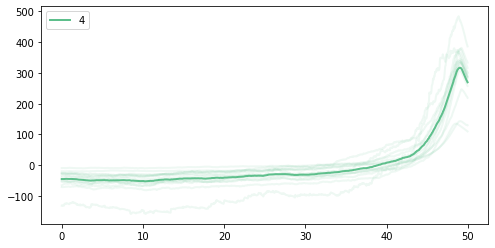

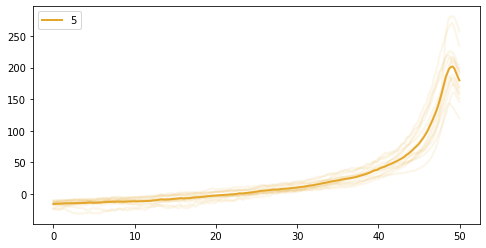

In [35]:
for i in set(df_sta_acsf_inh.labels_sta):
    fig,ax = plt.subplots(figsize=[8,4])
    plt.plot(np.arange(0,50,1/20),np.vstack(df_sta_acsf_inh[df_sta_acsf_inh.labels_sta==i]['sta']).T[50*20:],c=coherence_colors[i],linewidth=2,alpha=0.1)
    plt.plot(np.arange(0,50,1/20),np.mean(np.vstack(df_sta_acsf_inh[df_sta_acsf_inh.labels_sta==i]['sta']).T,axis=1)[50*20:],c=coherence_colors[i],linewidth=2,label=i)
    plt.legend()
    plt.show()

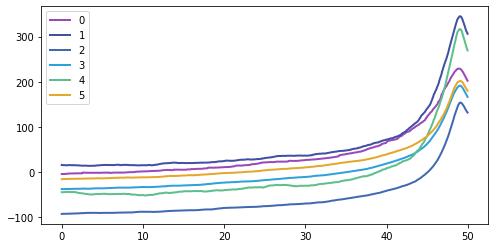

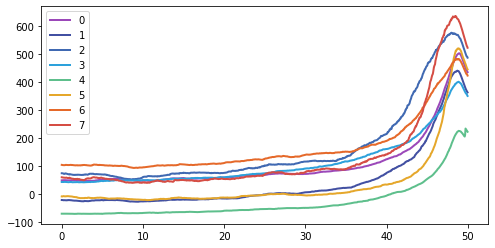

In [36]:
fig,ax = plt.subplots(figsize=[8,4])
for i in set(df_sta_acsf_inh.labels_sta):
    # plt.plot(np.arange(0,50,1/20),np.vstack(df_sta_acsf_inh[df_sta_acsf_inh.labels_sta==i]['sta']).T[50*20:],c=coherence_colors[i],linewidth=2,alpha=0.1)
    plt.plot(np.arange(0,50,1/20),np.mean(np.vstack(df_sta_acsf_inh[df_sta_acsf_inh.labels_sta==i]['sta']).T,axis=1)[50*20:],c=coherence_colors[i],linewidth=2,label=i)
plt.legend()
plt.show()

fig,ax = plt.subplots(figsize=[8,4])
for i in set(df_sta_acsf_exc.labels_sta):
    # plt.plot(np.arange(0,50,1/20),np.vstack(df_sta_acsf_exc[df_sta_acsf_exc.labels_sta==i]['sta']).T[50*20:],c=coherence_colors[i],linewidth=2,alpha=0.1)
    plt.plot(np.arange(0,50,1/20),np.mean(np.vstack(df_sta_acsf_exc[df_sta_acsf_exc.labels_sta==i]['sta']).T,axis=1)[50*20:],c=coherence_colors[i],linewidth=2,label=i)
plt.legend()
plt.show()

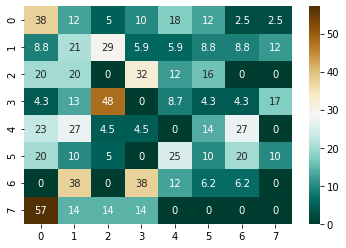

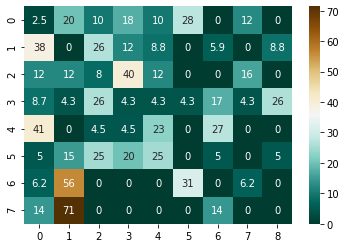

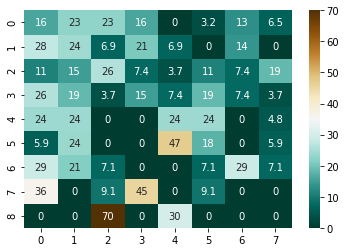

In [37]:
conf_df_exc_ephys = ephys_exc[ephys_exc.exp_name.isin(df_biophys_exc.exp_name)]
conf_df_exc_sta = df_sta_acsf_exc[df_sta_acsf_exc.exp_name.isin(df_biophys_exc.exp_name)]
conf_df_exc_bio = df_biophys_exc


return_confusion_matrix(conf_df_exc_ephys,conf_df_exc_sta,'labels_ephys','labels_sta')

return_confusion_matrix(conf_df_exc_ephys,conf_df_exc_bio,'labels_ephys','lables_bio')

return_confusion_matrix(conf_df_exc_bio,conf_df_exc_sta,'lables_bio','labels_sta')


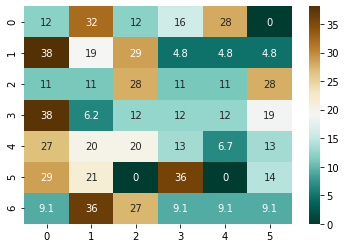

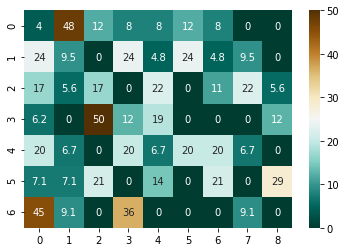

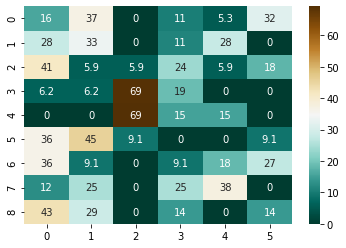

In [38]:
conf_df_inh_ephys = ephys_inh[ephys_inh.exp_name.isin(df_biophys_inh.exp_name)]
conf_df_inh_sta = df_sta_acsf_inh[df_sta_acsf_inh.exp_name.isin(df_biophys_inh.exp_name)]
conf_df_inh_bio = df_biophys_inh

return_confusion_matrix(conf_df_inh_ephys, conf_df_inh_sta, 'labels_ephys','labels_sta')
return_confusion_matrix(conf_df_inh_ephys, conf_df_inh_bio, 'labels_ephys','lables_bio')
return_confusion_matrix(conf_df_inh_bio  , conf_df_inh_sta, 'lables_bio'  ,'labels_sta')


In [41]:
from xg_boost_classifier import * 

In [44]:
conf_df_inh_ephys.columns[:-6]

Index(['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude'],
      dtype='object')

In [46]:
return_xg_boost_trees_classification(conf_df_inh_ephys[conf_df_inh_ephys.columns[:-6]].to_numpy(),conf_df_inh_ephys.labels_ephys)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


NameError: name 'mpl' is not defined